In [ ]:

import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn import tree

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import time 

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/NUS-BACT/datasets/master/hdb-resale-flat-prices.csv")
df.sample(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
128453,2022-06,HOUGANG,4 ROOM,473D,UPP SERANGOON CRES,16 TO 18,93.0,Model A,2017,94 years 01 month,596000.0
4639,2017-04,CENTRAL AREA,5 ROOM,1A,CANTONMENT RD,10 TO 12,106.0,Type S2,2011,92 years 10 months,909000.0
49588,2019-05,PASIR RIS,5 ROOM,146,PASIR RIS ST 11,04 TO 06,127.0,Improved,1995,74 years 08 months,445500.0


### EDA

In [ ]:
print(f'There are a total of {df.shape[0]} rows and {df.shape[1]} columns.')

There are a total of 135568 rows and 11 columns.


In [ ]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,remaining_lease_months,months_from_2017_jan,storey_interval,blocks_num
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,736,0,12,406
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,727,0,3,108
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,749,0,3,602
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,745,0,6,465
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,749,0,3,601


In [ ]:
for c in df.columns: 
  if df[c].dtype == 'object':
    print(c + ": " + str(df[c].nunique()) + "\n")

month: 69

town: 26

flat_type: 7

block: 2614

street_name: 559

storey_range: 17

flat_model: 21

remaining_lease: 654



In [ ]:
# check for null values
df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [ ]:
df.nunique()

month                    69
town                     26
flat_type                 7
block                  2614
street_name             559
storey_range             17
floor_area_sqm          169
flat_model               21
lease_commence_date      54
remaining_lease         654
resale_price           3251
dtype: int64

In [ ]:
df['resale_price'].describe()

count    1.355680e+05
mean     4.716172e+05
std      1.633406e+05
min      1.400000e+05
25%      3.500000e+05
50%      4.400000e+05
75%      5.558880e+05
max      1.418000e+06
Name: resale_price, dtype: float64

In [ ]:
# extract year & month from 'month' col 
df['sale_year'] = df['month'].apply(lambda x: x[:4])
df['sale_month'] = df['month'].apply(lambda x: x[-2:])
# df.drop(columns={'month'}, inplace=True)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Number of Sales')

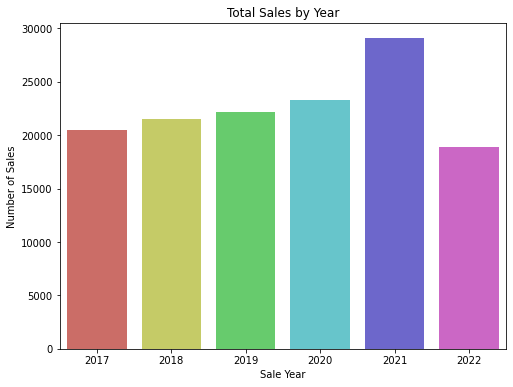

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.barplot(df['sale_year'].unique(),
                 df.groupby(['sale_year']).size(), palette = 'hls')
ax.set_title('Total Sales by Year')
ax.set_xlabel('Sale Year')
ax.set_ylabel('Number of Sales')

- Total sales were generally similar between 20,000-25,000 for 2017 to 2019.
- Surprisingly, 2021 had the highest number of sales at around 30,000 despite it being a year hit by COVID-19 which had also impacted the economy considerably.
- 2022 understandably has the lowest number of recorded sales since the dataset only contains sales data until September 2022.

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Number of Sales')

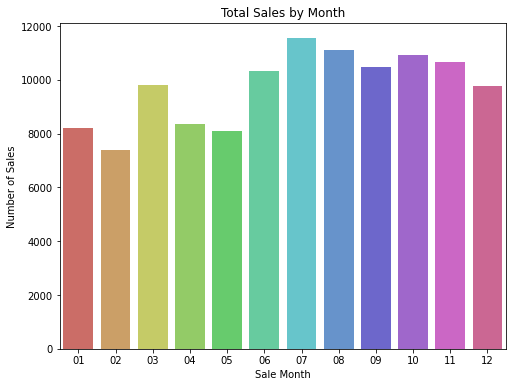

In [ ]:
plt.figure(figsize=(8,6))
df_no_2022 = df[~df['sale_year'].isin(['2022'])] # remove 2022 due to incomplete data

ax = sns.barplot(df_no_2022['sale_month'].unique(),
                 df_no_2022.groupby(['sale_month']).size(), palette = 'hls')
ax.set_title('Total Sales by Month')
ax.set_xlabel('Sale Month')
ax.set_ylabel('Number of Sales')

- There appears to be more sales concentrated in the second half of the year.

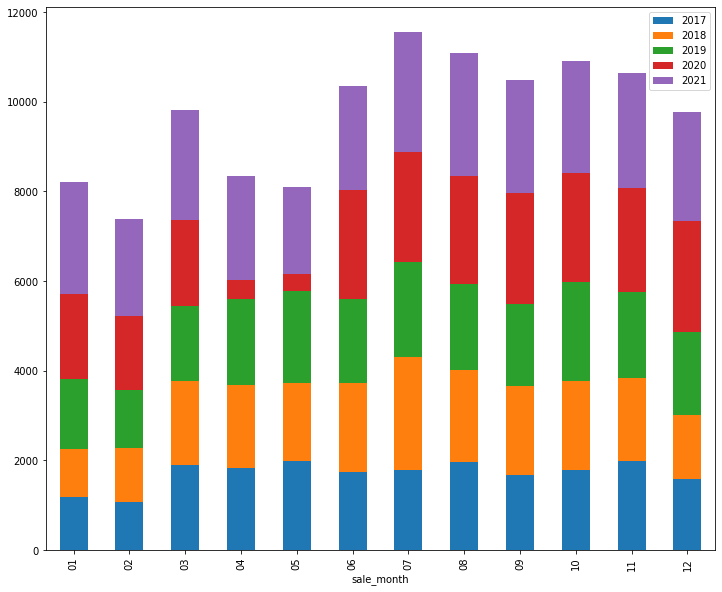

In [ ]:
df_no_2022.groupby('sale_month')['sale_year'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(12,10))
plt.legend(bbox_to_anchor=(1.0, 1.0))

- The sales transacted in April and May 2020 were the lowest across all years, which is very likely due to the fact that the SG government implemented circuit breaker lockdown measures from 7 April to 1 June 2020. 
- It is interesting to see that sales very quickly picked up from June 2020 onwards when circuit breaker measures were gradually lifted to levels slightly higher than pre-covid levels.

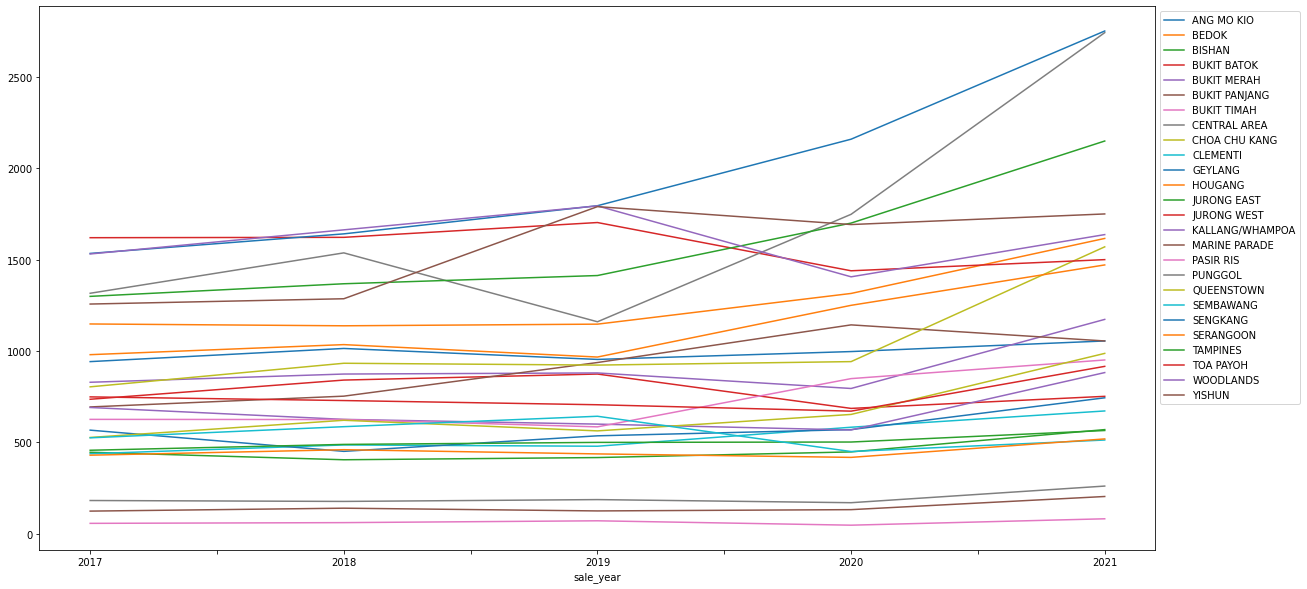

In [ ]:
# for each town, find number of sales per year and plot onto line chart to show trend over the years
yearly_sales_df = df[~df['sale_year'].isin(['2022'])] # exclude 2022 due to incomplete data
yearly_sales_df.groupby('sale_year')['town'].value_counts().unstack().plot(kind='line', figsize=(20,10))
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
# mature estates vs non-mature estates
# https://blog.carousell.com/property/mature-non-mature-estates-hdb-singapore/
non_mature_towns = ['Bukit Batok', 'Bukit Panjang', 'Choa Chu Kang', 'Hougang', 'Jurong East', 'Jurong West', 'Punggol',
                    'Sembawang', 'Sengkang', 'Tengah', 'Woodlands', 'Yishun']
non_mature_towns = [x.upper() for x in non_mature_towns]

non_mature_df = df[df['town'].isin(non_mature_towns)]
mature_df = df[~df['town'].isin(non_mature_towns)]   

df['inMatureTown'] = df['town'].apply(lambda x: 0 if x in non_mature_towns else 1) # 1 means is in mature town 

In [ ]:
# derive price_psm 
df['price_psm'] = df['resale_price'] / df['floor_area_sqm']

In [ ]:
df.groupby(['flat_type','inMatureTown'])['price_psm'].median().unstack().plot(kind='line', figsize=(12,10))
plt.legend(['Non-mature town', 'Mature town'])
plt.title('Median Resale Price per square metre by Flat Type in Mature Towns vs Non-Mature Towns')
plt.ylabel('Median Resale Price per square metre')
plt.xlabel('Flat Type')
plt.show()

- Comparing the median resale prices, it is obvious that hdb flats in mature towns have a price premium over those in non-mature estates across the various flat types.

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(y='town', x='resale_price', 
                 data=df, orient="h",
                 width=0.5,
                 palette="colorblind")

- As expected, hdb flats in the central area and those near to central region such as Queenstown and Bukit Timah command higher resale prices than other towns. 
- Similarly, flats in mature estates like Toa Payoh, Clementi and Bishan also sold at higher prices than those in non-mature estates like Seng Kang, Sembawang and Choa Chu Kang. 
- There are also a lot of outliers in several towns.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


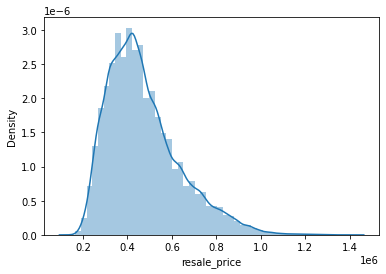

In [ ]:
sns.distplot(df['resale_price'])
plt.show()

- Resale price has a right-skewed distribution due to the presence of outliers.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


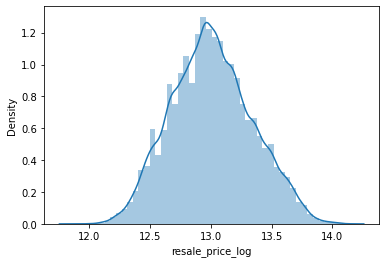

In [ ]:
# apply log transformation to resale_price
df['resale_price_log'] = np.log(df['resale_price'])

sns.distplot(df['resale_price_log'])
plt.show()

- Resale price now follows a normal distribution.

In [ ]:
# derive price_psm from resale_price_log to account for outliers
# df['price_psm'] = df['resale_price_log'] / df['floor_area_sqm']

In [ ]:
# # after scaling resale_price to normal dist
# df.groupby(['flat_type','inMatureTown'])['price_psm'].median().unstack().plot(kind='line', figsize=(12,10))
# plt.legend(['Non-mature town', 'Mature town'])
# plt.title('Median Resale Price per square metre by Flat Type in Mature Towns vs Non-Mature Towns')
# plt.ylabel('Median Resale Price per square metre')
# plt.xlabel('Flat Type')
# plt.show()

# After applying log-transformation to de-skew resale_price, it is interesting to observe that the median price psm actually very similar across the 
# different flat types in both mature and non-mature towns. 

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


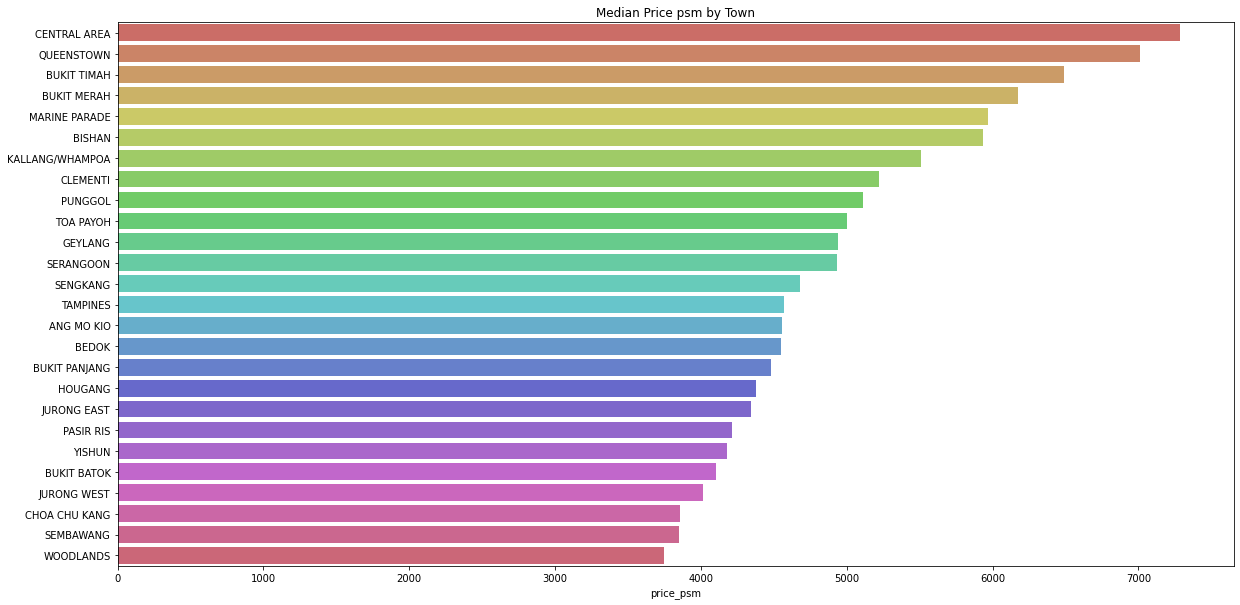

In [ ]:
#horizontal bar plot of median resale_price - not mean cos of outliers 
plt.figure(figsize=(20,10))
order = df.groupby('town')['price_psm'].median().sort_values(ascending=False).index
ax = sns.barplot(df.groupby('town')['price_psm'].median(), df['town'].unique(), orient='h', palette = 'hls', order=order)
ax.set_title('Median Price psm by Town')
plt.show()

- This further confirms that flats in mature towns tend to be able to sell for higher price psm compared to the non-mature counterparts. 
- The top few towns are all mature towns while the bottom few are non-mature towns.

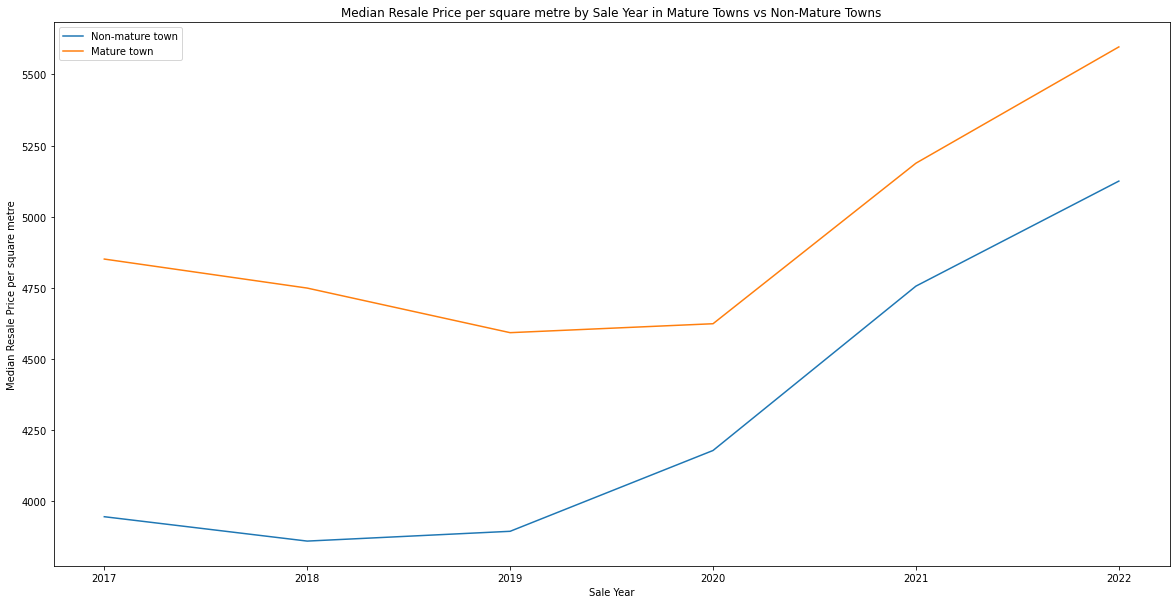

In [ ]:
df.groupby(['sale_year','inMatureTown'])['price_psm'].median().unstack().plot(kind='line', figsize=(20,10))
plt.legend(['Non-mature town', 'Mature town'])
plt.title('Median Resale Price per square metre by Sale Year in Mature Towns vs Non-Mature Towns')
plt.ylabel('Median Resale Price per square metre')
plt.xlabel('Sale Year')
plt.show()

- Although hdb flats in mature towns tend to command a premium over those in non-mature estates, the price gap between flats in the two town types is clearly narrowing over the years.
- This suggests increasing popularity of hdb flats in non-mature estates.

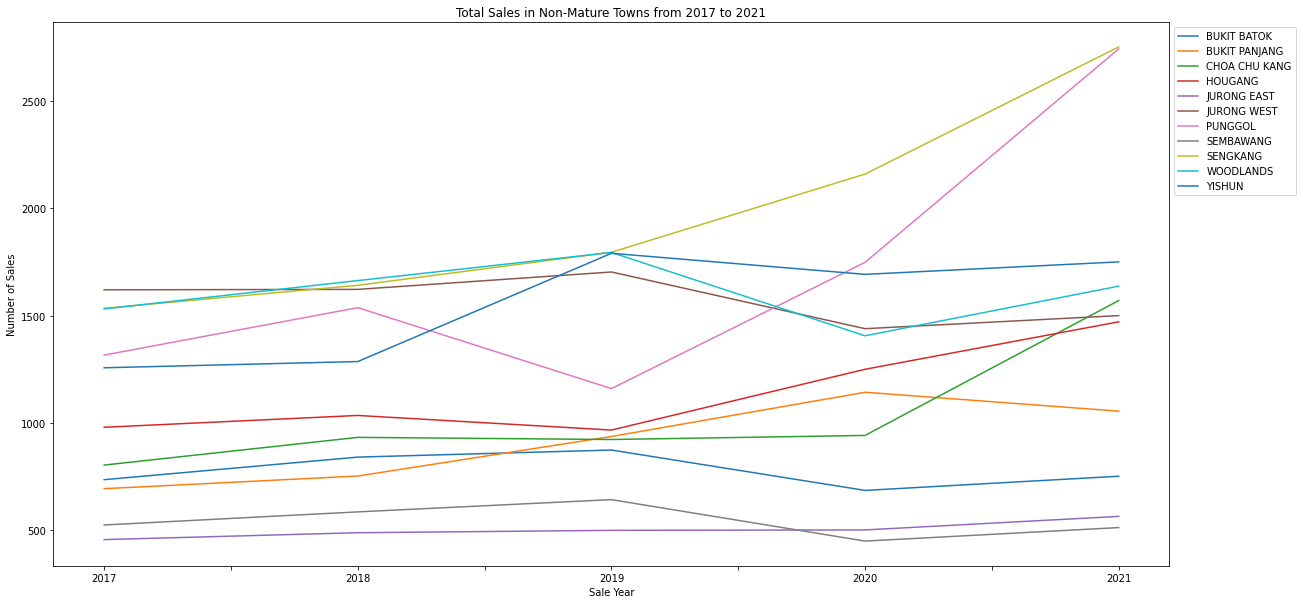

In [ ]:
non_mature_yearly_sales_df = non_mature_df[~non_mature_df['sale_year'].isin(['2022'])]
non_mature_yearly_sales_df.groupby('sale_year')['town'].value_counts().unstack().plot(kind='line', figsize=(20,10))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title('Total Sales in Non-Mature Towns from 2017 to 2021')
plt.ylabel('Number of Sales')
plt.xlabel('Sale Year')
plt.show()

- This confirms that there is an upward trend in sales in non-mature towns, especially in towns like Sengkang, Punggol, Choa Chu Kang and Hougang from 2019 onwards.
- In particular, in 2021, Sengkang and Punggol recorded higher sales of over 2,500 sales each compared to the two highest sales recorded in mature towns of Tampines and Bedok only had slightly over 2,000 and 1,500 sales respectively. [compared to mature town graph below]

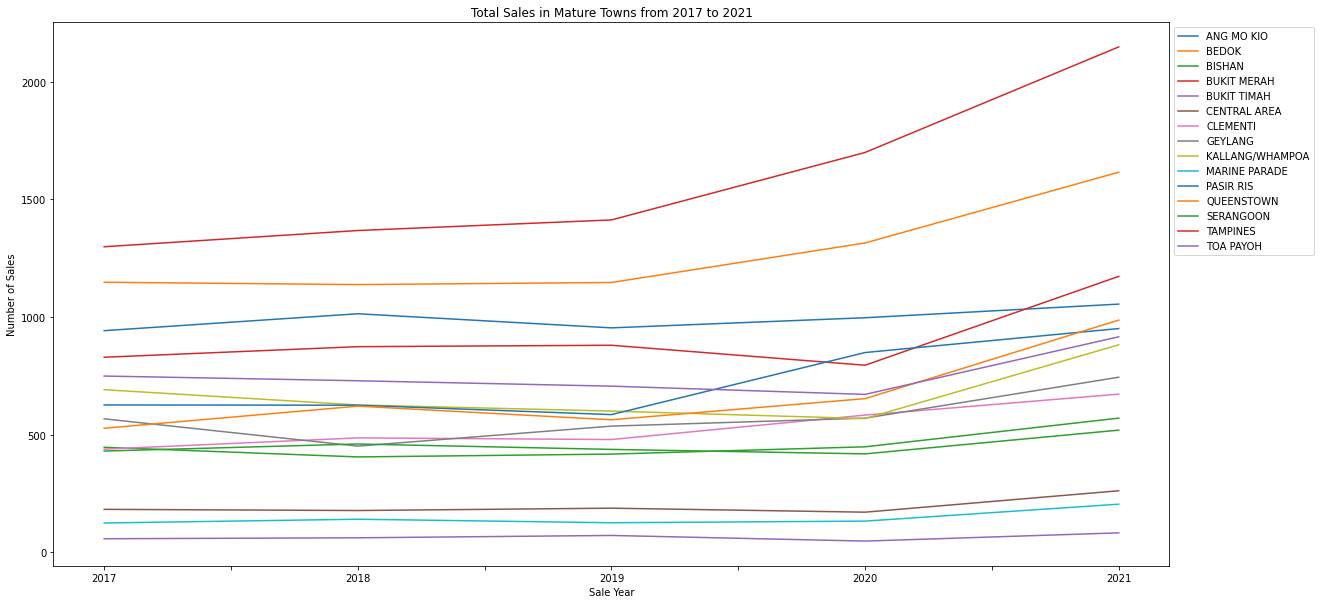

In [ ]:
mature_yearly_sales_df = mature_df[~mature_df['sale_year'].isin(['2022'])]
mature_yearly_sales_df.groupby('sale_year')['town'].value_counts().unstack().plot(kind='line', figsize=(20,10))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title('Total Sales in Mature Towns from 2017 to 2021')
plt.ylabel('Number of Sales')
plt.xlabel('Sale Year')
plt.show()

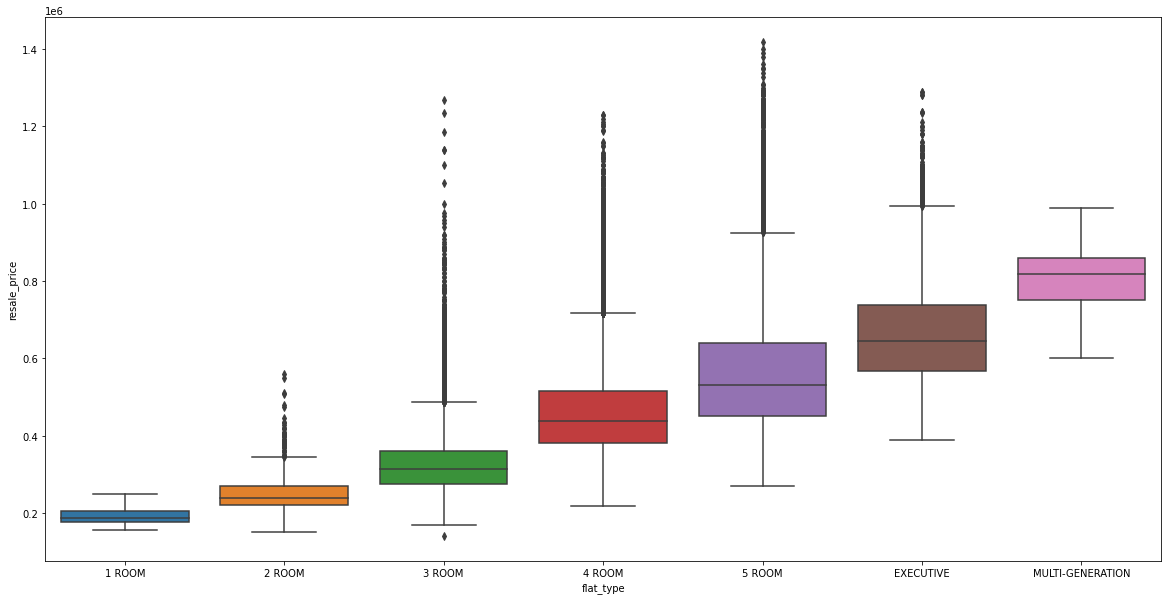

In [ ]:
# understand rs between 'flat_type' and 'resale_price' first

# set categorical order
df['flat_type'] = pd.Categorical(df['flat_type'],
                                   categories=['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION'],
                                   ordered=True)
plt.figure(figsize=(20,10))
sns.boxplot(x="flat_type", y="resale_price", data=df)

- There are significant outliers for 3 room, 4 room and 5 room flat types. 
- Generally, resale price follows upward trend as number of rooms increases which is intuitive and expected. 

Text(0.5, 0, 'Composition of flat_type')

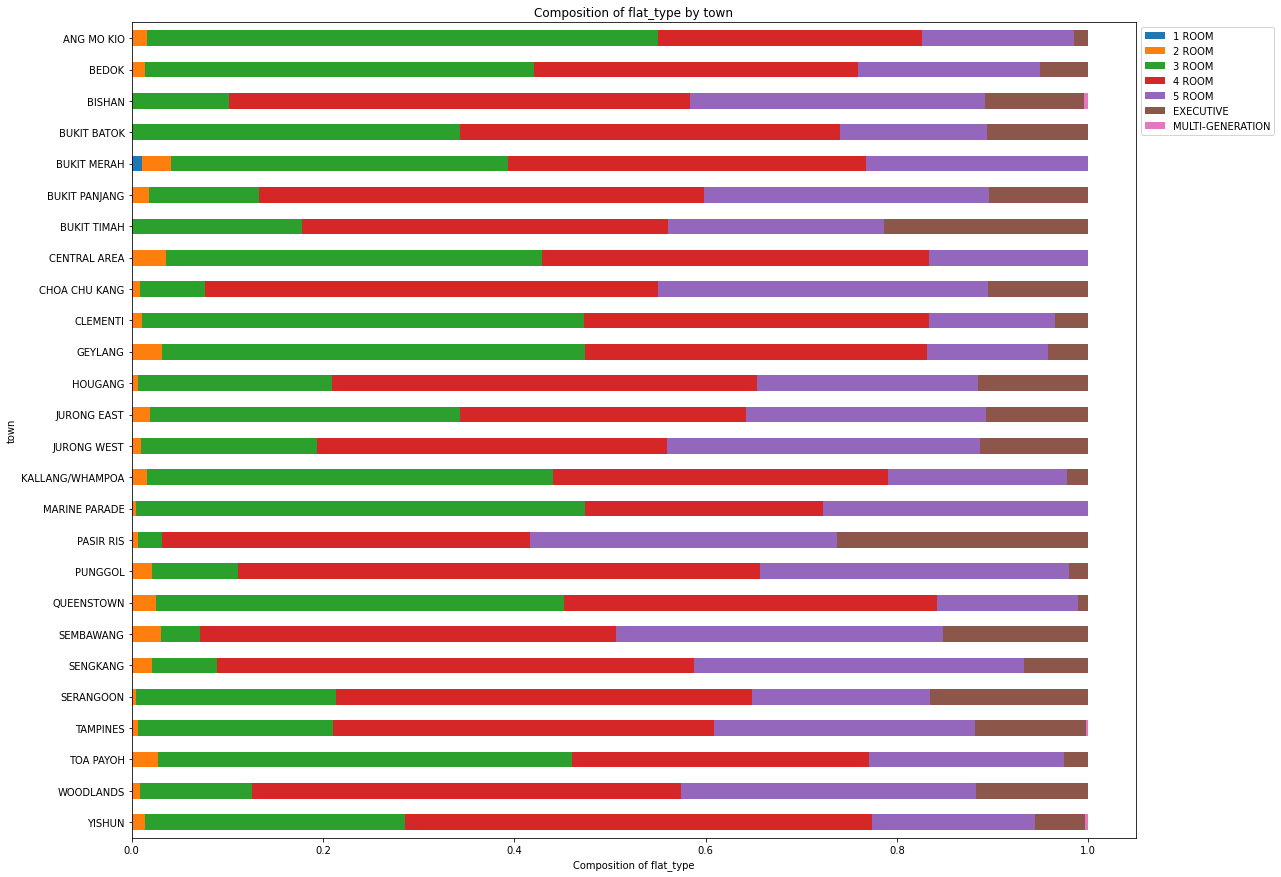

In [ ]:
df.groupby('town')['flat_type'].value_counts(normalize=True).unstack().sort_index(ascending=False).plot(kind='barh', stacked=True, figsize=(18,15))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title('Composition of flat_type by town')
plt.xlabel('Composition of flat_type')

- The most common flat types are 3-room and 4-room flats. 
- Least common ones are 1-room, 2-room and multi-generation flats. 
- Multi-generation flats are no longer being built by HDB which explains why it is barely observed in the plot.

In [ ]:
# yearly_sales_df = df[~df['sale_year'].isin(['2022'])]
# yearly_sales_df.groupby('sale_year')['flat_type'].value_counts().unstack().plot(kind='line', figsize=(20,10))
# plt.title('Total Sales by Flat Type from 2017 to 2021')
# plt.ylabel('Number of Sales')
# plt.xlabel('Flat Type')
# plt.show()

### Data Preprocessing + Feature Engineering

In [ ]:
# One hot encode categorical variable of original dataset 

st = time.time()

categorical_variables = []

for column in df.columns:
    if df[column].dtype == "object":
        categorical_variables.append(column)

enc_dt = OneHotEncoder(sparse=False, handle_unknown="ignore")

transformer_dt = ColumnTransformer([
    ("categorical", enc_dt, categorical_variables)
], remainder="passthrough")

transformer_dt.fit(df)
df_encoded_dt = pd.DataFrame(transformer_dt.transform(df), columns=transformer_dt.get_feature_names_out())
et = time.time()

df_encoded_dt.head()
df_encoded_dt.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135568 entries, 0 to 135567
Columns: 3970 entries, categorical__month_2017-01 to remainder__resale_price
dtypes: float64(3970)
memory usage: 4.0 GB


In [ ]:
print(f'There are a total of {df_encoded_dt.shape[0]} rows and {df_encoded_dt.shape[1]} columns.')

There are a total of 135568 rows and 3970 columns.


In [ ]:
print(str(et-st) + "s")

5.94030237197876s


In [ ]:
# Data Preprocessing
# Convert remaining_lease column to numeric_lease_months where the latter is a numeric data type of the number of months left in the remaining lease
remaining_lease = df['remaining_lease']
remaining_lease_months = []
for value in remaining_lease:
  try:
    year = int(value[:value.index("y") - 1])
    month = int(value[value.index("m") - 3:value.index("m") - 1])
    remaining_lease_months.append(year * 12 + month)
  except ValueError:
    year = int(value[:value.index("y") - 1])
    remaining_lease_months.append(year * 12)

df['remaining_lease_months'] = remaining_lease_months


# Convert month to ordinal data and storey range to a story interval
month_list = []
month = df['month']
current_month = month[0]
converted_month = 0
for m in month:
  if current_month == m:
    month_list.append(converted_month)
  else:
    current_month = m
    converted_month += 1
    month_list.append(converted_month)

df['months_from_2017_jan'] = month_list
df['storey_interval'] = df['storey_range'].apply(lambda x:int(x[6:])) 

marker = [str(i) for i in range(0,10)]
new_blocks = []

for block in df['block']:
  power = 0
  count = 0
  for i in range(len(block)-1,-1,-1):
    if block[i] in marker:
      count = count + (int(block[i])*(10**power))
      power += 1
  new_blocks.append(count)

df['blocks_num'] = new_blocks 

df1 = df.drop(columns=['month', 'storey_range', 'block', 'remaining_lease'])
df1.head()
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135568 entries, 0 to 135567
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   town                    135568 non-null  object 
 1   flat_type               135568 non-null  object 
 2   street_name             135568 non-null  object 
 3   floor_area_sqm          135568 non-null  float64
 4   flat_model              135568 non-null  object 
 5   lease_commence_date     135568 non-null  int64  
 6   resale_price            135568 non-null  float64
 7   remaining_lease_months  135568 non-null  int64  
 8   months_from_2017_jan    135568 non-null  int64  
 9   storey_interval         135568 non-null  int64  
 10  blocks_num              135568 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 11.4+ MB


In [ ]:
# One hot encode categorical variable
st = time.time()
categorical_variables = []

for column in df1.columns:
    if df1[column].dtype == "object":
        categorical_variables.append(column)

enc_dt = OneHotEncoder(sparse=False, handle_unknown="ignore")

transformer_dt = ColumnTransformer([
    ("categorical", enc_dt, categorical_variables)
], remainder="passthrough")

transformer_dt.fit(df1)
df1_encoded_dt = pd.DataFrame(transformer_dt.transform(df1), columns=transformer_dt.get_feature_names_out())
et = time.time()

df1_encoded_dt.head()
df1_encoded_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135568 entries, 0 to 135567
Columns: 620 entries, categorical__town_ANG MO KIO to remainder__blocks_num
dtypes: float64(620)
memory usage: 641.3 MB


In [ ]:
# Set "resale_price" as the y variable
y = df1_encoded_dt["remainder__resale_price"] 

# Set everything other than "resale_price" as the X variables
X = df1_encoded_dt.drop(columns=["remainder__resale_price"], errors="ignore") 

# To conduct hyperparameter tuning with cross validation, 100k+ rows of data is too slow. Thus, we will use only 10% of the train set for hyperparameter tuning first.
X_rem, X_test, y_rem, y_test = train_test_split(X,y, test_size=0.2)
X_train, X_hyper, y_train, y_hyper = train_test_split(X_rem,y_rem, train_size=0.9)

#Train: X_rem, y_rem, X_train, y_train 
#Test: X_hyper, y_hyper, X_test, y_test 

In [ ]:
# Before hyperparameter tuning
xgb_before = xgb.XGBRegressor(seed=20)
xgb_before.fit(X_train, y_train)
pred = xgb_before.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE using default hyperparameters : % f" %(rmse))


[12:59:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

In [ ]:

# Hyperparameter tuning
params = { 'max_depth': [3,7,10,15],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 300, 500],
           'colsample_bytree': [0.3, 0.7]}
xgb_r_hyper = xgb.XGBRegressor(seed=20)
clf_hyper = GridSearchCV(estimator=xgb_r_hyper, 
                   param_grid=params,
                   scoring='neg_root_mean_squared_error', 
                   verbose=1, 
                   cv=3)
clf_hyper.fit(X_hyper, y_hyper)
print("Best parameters:", clf_hyper.best_params_)
print("Lowest RMSE: ", (-clf_hyper.best_score_))
# Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500}
# Lowest RMSE:  36193.69697875495

In [ ]:
# Fitting the actual training data
xgb_r = xgb.XGBRegressor(max_depth = 15, n_estimators = 500, learning_rate = 0.1, colsample_bytree = 0.3)
xgb_r.fit(X_train, y_train)
pred_train = xgb_r.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
print("RMSE for train data: % f" %(rmse_train))

[12:59:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

In [ ]:

# Predicting from test data
pred_test = xgb_r.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
r2_test = r2_score(y_test, pred_test)
print("RMSE for test data: % f" %(rmse_test))
print(r2_test)
# RMSE for test data: 24910.738870

NameError: ignored

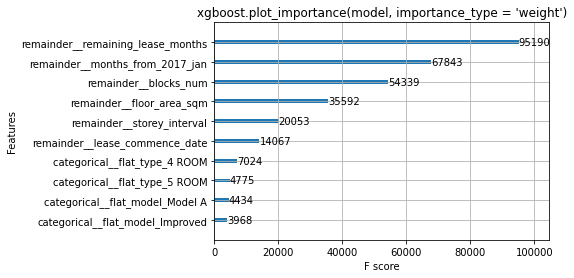

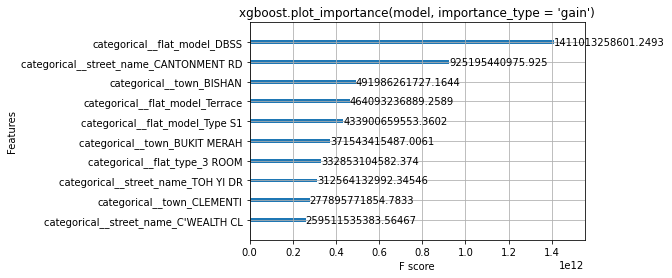

In [ ]:
xgb.plot_importance(xgb_r, importance_type="weight", max_num_features=10)
plt.title("xgboost.plot_importance(model, importance_type = 'weight')")
plt.show()
xgb.plot_importance(xgb_r, importance_type="gain", max_num_features=10)
plt.title("xgboost.plot_importance(model, importance_type = 'gain')")
plt.show()
